## PyTorch Conditional GAN

This kernel is a PyTorch implementation of [Conditional GAN](https://arxiv.org/abs/1411.1784), which is a GAN that allows you to choose the label of the generated image. The generator and the discriminator are going to be simple feedforward networks, so I guess the images won't be as good as in this [nice kernel](https://www.kaggle.com/sgamez/fashion-ac-gan-with-keras) by [Sergio Gámez](https://www.kaggle.com/sgamez). I used [this implementation](https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/cgan/cgan.py) by [eriklindernoren](https://github.com/eriklindernoren) as inspiration.

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [20]:
!ls ../../input

celeba-dataset.zip		      t10k-labels-idx1-ubyte
fashion-mnist_test.csv		      test
fashion-mnist_train.csv		      train
fashionmnist.zip		      train-images-idx3-ubyte
histopathologic-cancer-detection.zip  train_labels.csv
img_align_celeba		      train-labels-idx1-ubyte
t10k-images-idx3-ubyte


 Let's start by defining a Dataset class:
* [Data Loading and Processing Tutorial on PyTorch's documentation](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)
* [torchvision](https://github.com/pytorch/vision) has a [built-in class for Fashion MNIST](https://pytorch.org/docs/stable/torchvision/datasets.html#fashion-mnist)

In [32]:
class FashionMNIST(Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        fashion_df = pd.read_csv('../../input/fashion-mnist_train.csv')
        self.labels = fashion_df.label.values
        self.images = fashion_df.iloc[:, 1:].values.astype('uint8').reshape(-1, 28, 28)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img = Image.fromarray(self.images[idx])
        
        if self.transform:
            img = self.transform(img)

        return img, label

In [33]:
dataset = FashionMNIST()
dataset[0][0]

In [34]:

# transform = transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
# ])


In [35]:

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,), std=(0.5,))
])
dataset = FashionMNIST(transform=transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

Now let's define the generator and the discriminator, which are simple MLPs. I'm going to use an embedding layer for the label:

In [36]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        x = x.view(x.size(0), 784)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze()

In [37]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(x.size(0), 28, 28)

In [38]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()

In [39]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)

In [40]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).cuda())
    g_loss.backward()
    g_optimizer.step()
#     return g_loss.data[0]
    return g_loss.item()

In [41]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    # train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).cuda())
    
    # train with fake images
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).cuda())
    
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
#     return d_loss.data[0]
    return d_loss.item()

Starting epoch 0...
g_loss: 5.751616477966309, d_loss: 0.08091568201780319


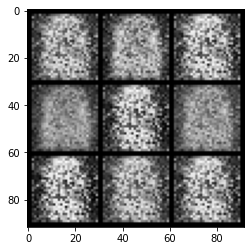

Starting epoch 1...
g_loss: 4.774593353271484, d_loss: 0.1830144226551056


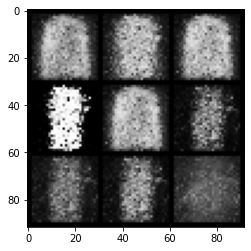

Starting epoch 2...
g_loss: 3.510423421859741, d_loss: 0.4509007930755615


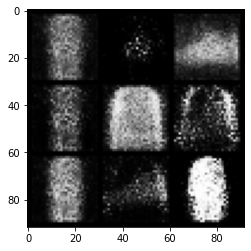

Starting epoch 3...
g_loss: 2.97988224029541, d_loss: 0.7021611928939819


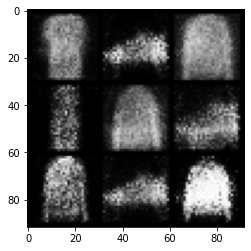

Starting epoch 4...
g_loss: 2.628683090209961, d_loss: 0.42018699645996094


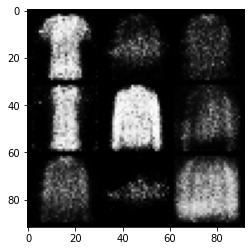

Starting epoch 5...
g_loss: 2.5936083793640137, d_loss: 0.7442734241485596


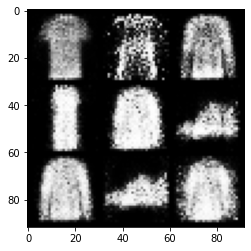

Starting epoch 6...
g_loss: 1.969252109527588, d_loss: 0.5271769762039185


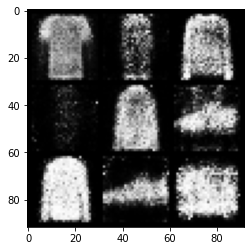

Starting epoch 7...
g_loss: 1.5741233825683594, d_loss: 0.8316668272018433


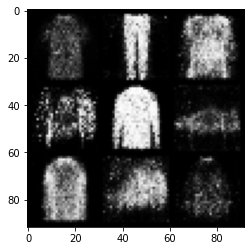

Starting epoch 8...
g_loss: 2.119236469268799, d_loss: 0.9095333814620972


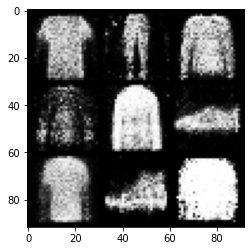

Starting epoch 9...
g_loss: 1.5100442171096802, d_loss: 0.8069972395896912


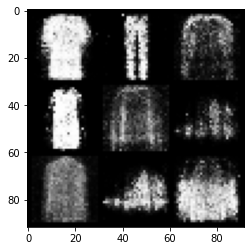

Starting epoch 10...
g_loss: 1.910747766494751, d_loss: 0.9458029270172119


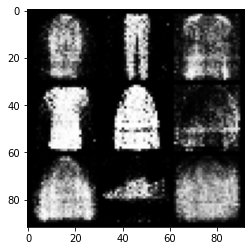

Starting epoch 11...
g_loss: 1.8688256740570068, d_loss: 1.0059571266174316


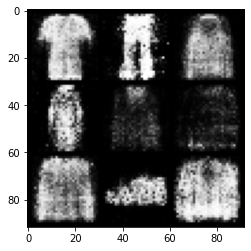

Starting epoch 12...
g_loss: 1.6086549758911133, d_loss: 0.885454535484314


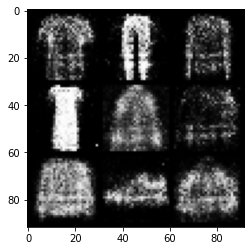

Starting epoch 13...
g_loss: 1.9948041439056396, d_loss: 0.6202706694602966


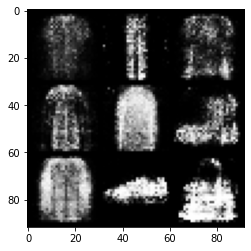

Starting epoch 14...
g_loss: 1.5382080078125, d_loss: 0.8877038955688477


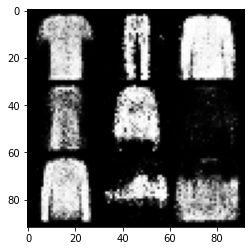

Starting epoch 15...
g_loss: 1.4723169803619385, d_loss: 1.109476923942566


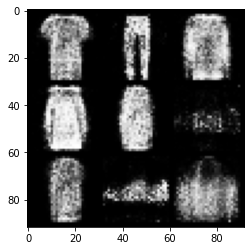

Starting epoch 16...
g_loss: 1.4462305307388306, d_loss: 1.0038948059082031


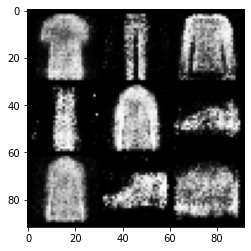

Starting epoch 17...
g_loss: 1.125919222831726, d_loss: 0.9382131099700928


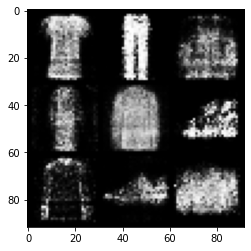

Starting epoch 18...
g_loss: 1.267263650894165, d_loss: 1.0586146116256714


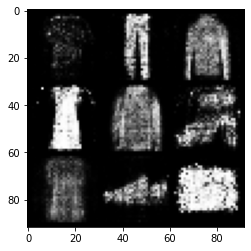

Starting epoch 19...
g_loss: 1.562087059020996, d_loss: 0.9918919205665588


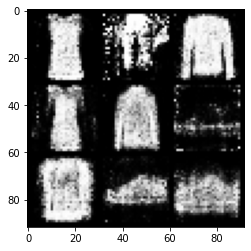

Starting epoch 20...
g_loss: 1.8001196384429932, d_loss: 1.0046029090881348


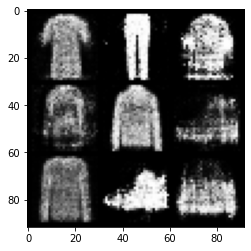

Starting epoch 21...
g_loss: 1.5281943082809448, d_loss: 0.9107348918914795


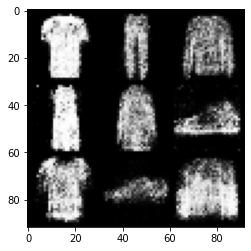

Starting epoch 22...
g_loss: 1.7001943588256836, d_loss: 1.3192577362060547


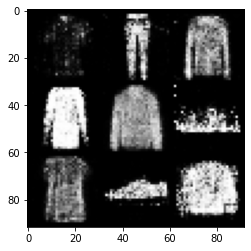

Starting epoch 23...
g_loss: 1.2873698472976685, d_loss: 0.9441855549812317


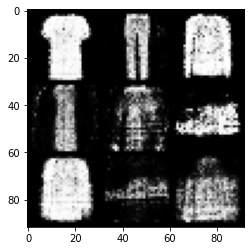

Starting epoch 24...
g_loss: 1.2842336893081665, d_loss: 1.2482659816741943


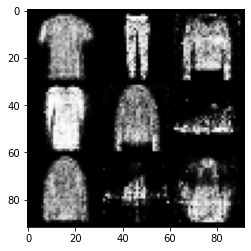

Starting epoch 25...
g_loss: 1.1111905574798584, d_loss: 1.1216269731521606


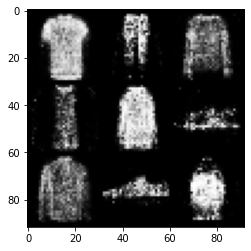

Starting epoch 26...
g_loss: 1.1742897033691406, d_loss: 0.921908974647522


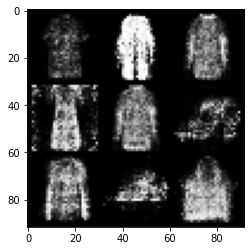

Starting epoch 27...
g_loss: 1.2415831089019775, d_loss: 1.0211790800094604


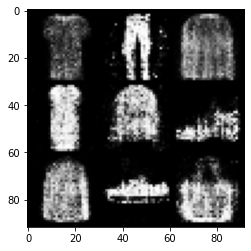

Starting epoch 28...
g_loss: 0.9344831705093384, d_loss: 1.2136237621307373


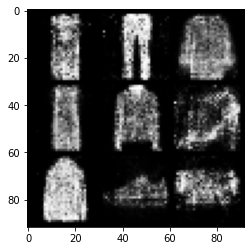

Starting epoch 29...


In [ ]:
num_epochs = 30
n_critic = 5
display_step = 300
for epoch in range(num_epochs):
    print('Starting epoch {}...'.format(epoch))
    for i, (images, labels) in enumerate(data_loader):
        real_images = Variable(images).cuda()
        labels = Variable(labels).cuda()
        generator.train()
        batch_size = real_images.size(0)
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)
        

        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)

    generator.eval()
    print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))
    z = Variable(torch.randn(9, 100)).cuda()
    labels = Variable(torch.LongTensor(np.arange(9))).cuda()
    sample_images = generator(z, labels).unsqueeze(1).data.cpu()
    grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()

## Results

In [ ]:
z = Variable(torch.randn(100, 100)).cuda()
labels = Variable(torch.LongTensor([i for _ in range(10) for i in range(10)])).cuda()
sample_images = generator(z, labels).unsqueeze(1).data.cpu()
grid = make_grid(sample_images, nrow=10, normalize=True).permute(1,2,0).numpy()
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(grid)
_ = plt.yticks([])
_ = plt.xticks(np.arange(15, 300, 30), ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], rotation=45, fontsize=20)
